# Imports

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Bidirectional, LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import bz2
import csv
import re


# Loading Datasets

In [8]:
import bz2


# Load a subset of the training data
with bz2.BZ2File("/kaggle/input/amazonreviews/train.ft.txt.bz2") as f:
    training_data = [f.readline().decode('utf-8').strip() for _ in range(3000)]

# Load a subset of the test data
with bz2.BZ2File("/kaggle/input/amazonreviews/test.ft.txt.bz2") as f:
    test_data = [f.readline().decode('utf-8').strip() for _ in range(1000)]

# Print the subset sizes
print("Training data subset size:", len(training_data))
print("Test data subset size:", len(test_data))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/amazonreviews/train.ft.txt.bz2'

# Preparing Dataset

In [7]:
training_data[0]

'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [8]:
# Split the data into labels and texts
training_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in training_data]
training_texts = [re.sub(r'__label__\d ', '', line) for line in training_data]

test_labels = [int(re.findall(r'__label__(\d)', line)[0]) for line in test_data]
test_texts = [re.sub(r'__label__\d ', '', line) for line in test_data]

# Convert labels to binary (0 and 1)
training_labels = [0 if label == 1 else 1 for label in training_labels]
test_labels = [0 if label == 1 else 1 for label in test_labels]


In [9]:
test_labels[:20]

[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]

# Text Cleaning

In [10]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download stopwords if not already downloaded
nltk.download('stopwords')

def clean_text(text):
    """Cleans text by lowercasing, removing stopwords, and applying stemming."""
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove non-alphabetic characters (keep spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize and remove stopwords, apply stemming
    words = text.split()
    words = [ps.stem(word) for word in words if word not in stop_words]
    
    # Join words back into a string
    return " ".join(words)

# Apply function to training and test texts
training_texts = [clean_text(text) for text in training_texts]
test_texts = [clean_text(text) for text in test_texts]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
training_texts[0]

'stune even nongam sound track beauti paint seneri mind well would recomend even peopl hate vid game music play game chrono cross game ever play best music back away crude keyboard take fresher step grate guitar soul orchestra would impress anyon care listen'

# Tokenization

In [12]:
# Tokenization and padding
max_words = 1000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(training_texts)

X_train = tokenizer.texts_to_sequences(training_texts)
X_test = tokenizer.texts_to_sequences(test_texts)

X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)


In [13]:
X_train = np.array(X_train)
print(X_train.shape)
X_test = np.array(X_test)
print(X_test.shape)
y_train = np.array(training_labels)
print(y_train.shape)
y_test = np.array(test_labels)
print(y_test.shape)

(3000, 100)
(1000, 100)
(3000,)
(1000,)


# Training RNN

Epoch 1/50
6/6 [==============================] - 8s 466ms/step - loss: 0.8920 - accuracy: 0.4943 - val_loss: 0.7462 - val_accuracy: 0.5260
Epoch 2/50
6/6 [==============================] - 2s 320ms/step - loss: 0.8309 - accuracy: 0.4897 - val_loss: 0.7213 - val_accuracy: 0.4900
Epoch 3/50
6/6 [==============================] - 1s 205ms/step - loss: 0.7920 - accuracy: 0.5110 - val_loss: 0.7246 - val_accuracy: 0.4890
Epoch 4/50
6/6 [==============================] - 2s 244ms/step - loss: 0.7643 - accuracy: 0.5253 - val_loss: 0.7321 - val_accuracy: 0.5000
Epoch 5/50
6/6 [==============================] - 1s 204ms/step - loss: 0.7687 - accuracy: 0.5073 - val_loss: 0.7357 - val_accuracy: 0.5030
Epoch 6/50
6/6 [==============================] - 1s 209ms/step - loss: 0.7479 - accuracy: 0.5233 - val_loss: 0.7294 - val_accuracy: 0.5030
Epoch 7/50
6/6 [==============================] - 1s 207ms/step - loss: 0.7463 - accuracy: 0.5170 - val_loss: 0.7198 - val_accuracy: 0.5010
Epoch 8/50
6/6 [====

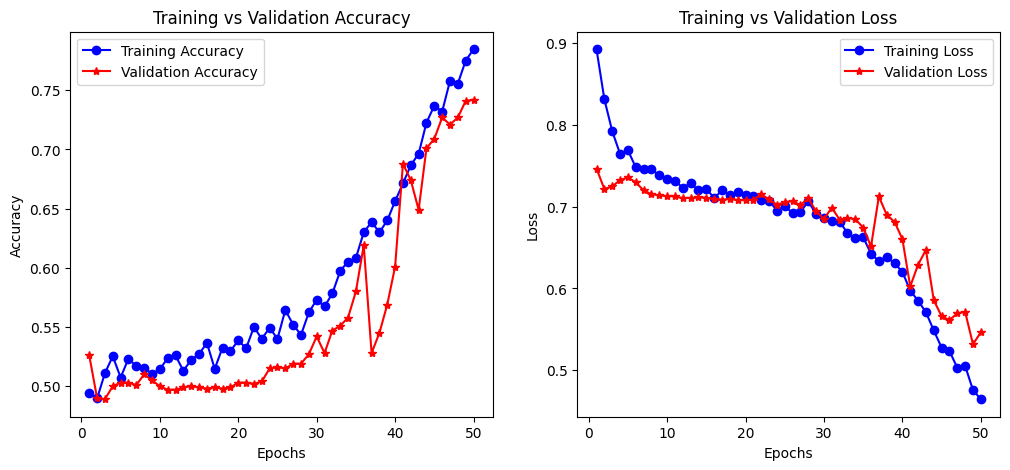

In [14]:


# Define improved RNN model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    SimpleRNN(128, return_sequences=True, dropout=0.3),  # RNN layer with dropout
    LayerNormalization(),  # Added normalization for stability
    SimpleRNN(128, dropout=0.3),  # Second RNN layer
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()


In [15]:
# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

32/32 [==============================] - 1s 14ms/step
Confusion Matrix:
[[424  74]
 [184 318]]
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.85      0.77       498
           1       0.81      0.63      0.71       502

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000



# Training LSTM

In [16]:
# Define improved model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),  # Added recurrent dropout
    LayerNormalization(),  # Added normalization for stability
    Dropout(0.3),
    Bidirectional(LSTM(128, recurrent_dropout=0.2)),  
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/50
6/6 [==============================] - 18s 1s/step - loss: 0.8678 - accuracy: 0.5123 - val_loss: 0.7062 - val_accuracy: 0.5260
Epoch 2/50
6/6 [==============================] - 7s 1s/step - loss: 0.7959 - accuracy: 0.5187 - val_loss: 0.6925 - val_accuracy: 0.5340
Epoch 3/50
6/6 [==============================] - 7s 1s/step - loss: 0.7505 - accuracy: 0.5420 - val_loss: 0.6763 - val_accuracy: 0.5710
Epoch 4/50
6/6 [==============================] - 7s 1s/step - loss: 0.7188 - accuracy: 0.5563 - val_loss: 0.6791 - val_accuracy: 0.5490
Epoch 5/50
6/6 [==============================] - 7s 1s/step - loss: 0.7116 - accuracy: 0.5700 - val_loss: 0.6668 - val_accuracy: 0.5810
Epoch 6/50
6/6 [==============================] - 7s 1s/step - loss: 0.6908 - accuracy: 0.5793 - val_loss: 0.6590 - val_accuracy: 0.5990
Epoch 7/50
6/6 [==============================] - 7s 1s/step - loss: 0.6701 - accuracy: 0.6010 - val_loss: 0.6528 - val_accuracy: 0.6240
Epoch 8/50
6/6 [========================

# Model Evaluation

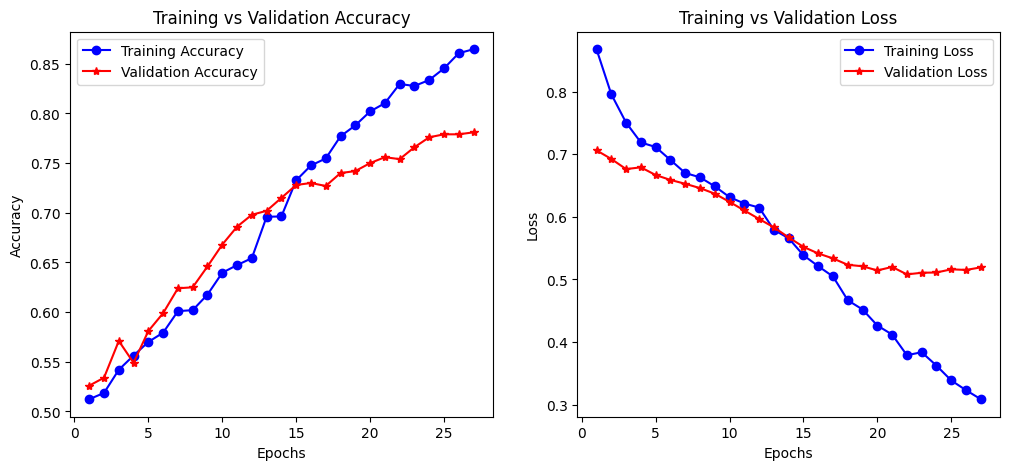

In [17]:
import matplotlib.pyplot as plt

# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()


In [18]:
# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

32/32 [==============================] - 3s 84ms/step
Confusion Matrix:
[[363 135]
 [111 391]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       498
           1       0.74      0.78      0.76       502

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



# Training GRU

Epoch 1/50
6/6 [==============================] - 11s 815ms/step - loss: 0.9165 - accuracy: 0.4927 - val_loss: 0.7811 - val_accuracy: 0.4940
Epoch 2/50
6/6 [==============================] - 4s 693ms/step - loss: 0.8626 - accuracy: 0.5077 - val_loss: 0.7525 - val_accuracy: 0.5120
Epoch 3/50
6/6 [==============================] - 4s 623ms/step - loss: 0.8262 - accuracy: 0.5127 - val_loss: 0.7435 - val_accuracy: 0.5050
Epoch 4/50
6/6 [==============================] - 4s 631ms/step - loss: 0.7907 - accuracy: 0.5230 - val_loss: 0.7416 - val_accuracy: 0.5110
Epoch 5/50
6/6 [==============================] - 4s 634ms/step - loss: 0.7875 - accuracy: 0.5337 - val_loss: 0.7413 - val_accuracy: 0.5190
Epoch 6/50
6/6 [==============================] - 4s 603ms/step - loss: 0.7663 - accuracy: 0.5353 - val_loss: 0.7373 - val_accuracy: 0.5320
Epoch 7/50
6/6 [==============================] - 4s 620ms/step - loss: 0.7378 - accuracy: 0.5577 - val_loss: 0.7299 - val_accuracy: 0.5390
Epoch 8/50
6/6 [===

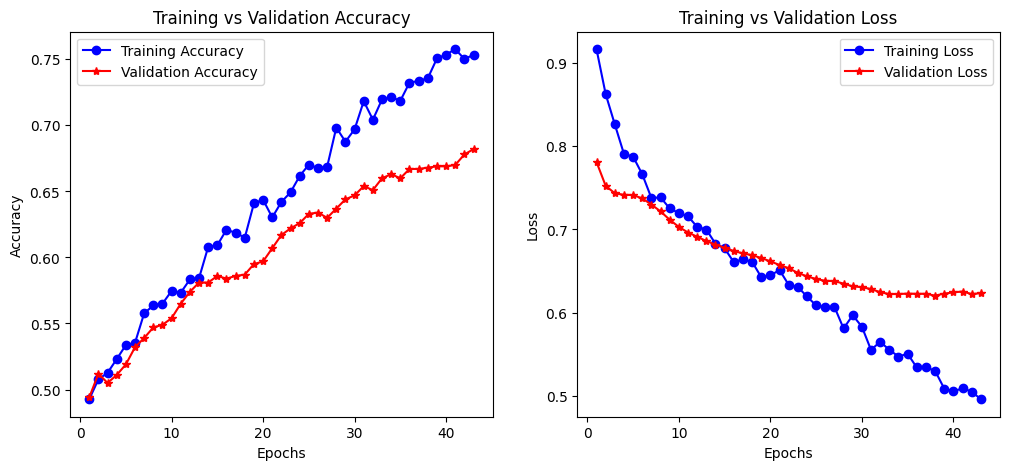

32/32 [==============================] - 2s 42ms/step
Confusion Matrix:
[[397 101]
 [231 271]]
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.80      0.71       498
           1       0.73      0.54      0.62       502

    accuracy                           0.67      1000
   macro avg       0.68      0.67      0.66      1000
weighted avg       0.68      0.67      0.66      1000



In [19]:


# Define improved GRU model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=300, input_length=max_sequence_length),  # Increased embedding size
    GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),  # GRU layer with dropout
    LayerNormalization(),  # Added normalization for stability
    GRU(128, dropout=0.3, recurrent_dropout=0.2),  # Second GRU layer
    LayerNormalization(),
    Dropout(0.3),
    Dense(64, activation="relu"),  # Extra dense layer
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile with lower learning rate
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=5e-5), metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Extract values from history
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()



# Evaluate with a confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Detection System

In [41]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_sentiment(text, model, tokenizer, max_sequence_length=100):
    # clean text
    text = clean_text(text)
    # Convert text to sequence
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
    
    # Predict sentiment
    prediction = model.predict(padded_sequence)[0][0]  # Extract scalar value
    
    # Determine sentiment
    sentiment = "Positive 😊" if prediction > 0.5 else "Negative 😡"
    
    return sentiment, float(prediction)

# Example usage:
test_sentences = [
    "I love this product! It's amazing.",
    "This is the worst service I have ever experienced.",
    "The movie was okay, not great but not terrible either."
]

for sentence in test_sentences:
    sentiment, confidence = predict_sentiment(sentence, model, tokenizer)
    print(f"Text: {sentence}\nPredicted Sentiment: {sentiment} (Confidence: {confidence:.4f})\n")


1/1 [==============================] - 0s 112ms/step
Text: I love this product! It's amazing.
Predicted Sentiment: Positive 😊 (Confidence: 0.9017)

1/1 [==============================] - 0s 112ms/step
Text: This is the worst service I have ever experienced.
Predicted Sentiment: Negative 😡 (Confidence: 0.1077)

1/1 [==============================] - 0s 114ms/step
Text: The movie was okay, not great but not terrible either.
Predicted Sentiment: Negative 😡 (Confidence: 0.2425)



In [43]:
model.save("lstm_model.h5")  # Saves architecture, weights & optimizer


import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [45]:
import tensorflow as tf
print(tf.__version__)


2.12.0
